### Load librairies

In [105]:
import joblib 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats

### Import data

In [73]:
X_train = joblib.load("../data/processed/X_train_final.pkl")
X_test = joblib.load("../data/processed/X_test_final.pkl")
y_train = joblib.load("../data/processed/y_train.pkl")
y_test = joblib.load("../data/processed/y_test.pkl")

In [74]:
y_train.head()

156355     4387
76931      3450
225559    60589
9114       6296
200676     7312
Name: price, dtype: int64

## Training model

We will first try a normal linear regression and then we will try to get a better R² changing things like the number of features

In [75]:
modelv1=LinearRegression()
modelv1.fit(X_train,y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [76]:
y_pred=modelv1.predict(X_test)

In [77]:
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
R2=r2_score(y_test,y_pred)

print(f'The R² score is: {R2}')
print(f'The mean absolue error is: {mae}')
print(f'The mean squared error is: {mse}')

The R² score is: 0.9112604814451996
The mean absolue error is: 4509.168020169488
The mean squared error is: 45677547.24489513


Pretty good R² score, let's plot the residuals

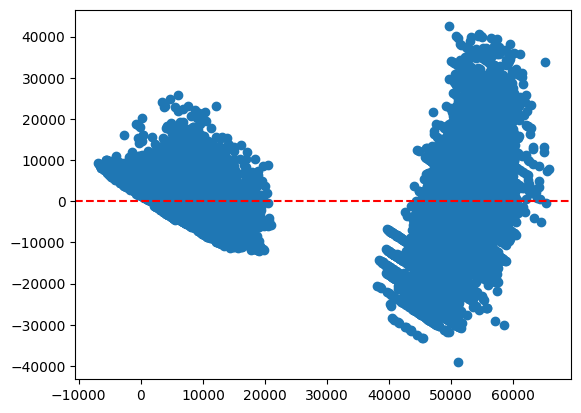

In [78]:
residual=y_test -y_pred
plt.scatter(y_pred, residual)
plt.axhline(0, color='red', linestyle='--')
plt.show()

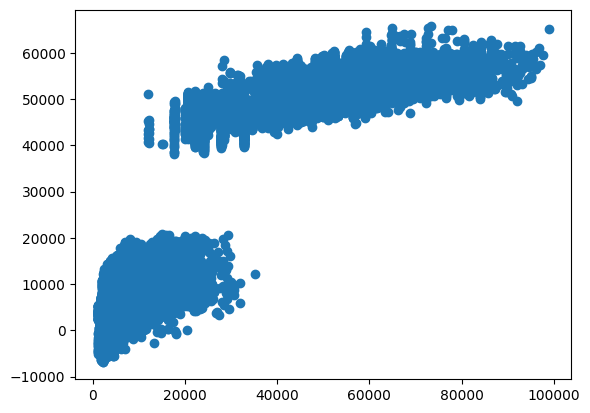

In [79]:
plt.scatter(y_test,y_pred)
plt.show()

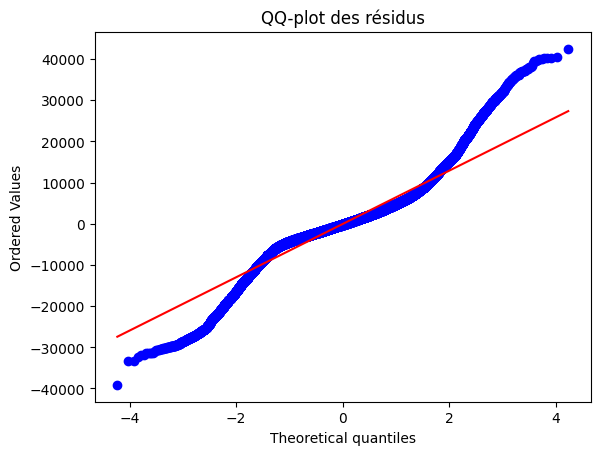

In [80]:
stats.probplot(residual, dist="norm", plot=plt)
plt.title("QQ-plot des résidus")
plt.show()

We can see that there is two groups, this is surement due to the feature 'class'. There are signs of heteroscedasticity.

Let's see the coefficients of our features

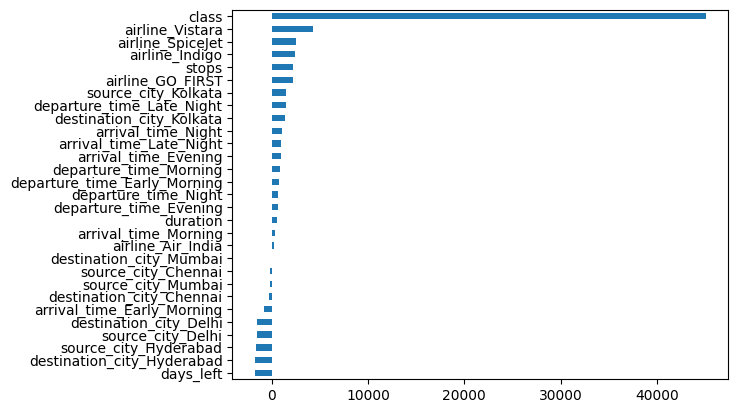

In [81]:
pd.Series(modelv1.coef_, index=X_train.columns).sort_values().plot(kind='barh')
plt.show()

Let's try to transform our feature 'price' with a logaritmic 

In [82]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [83]:
model_log = LinearRegression()
model_log.fit(X_train, y_train_log)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [84]:
y_pred_log = model_log.predict(X_test)
y_pred = np.expm1(y_pred_log)  

In [85]:
mse=mean_squared_error(y_test,y_pred)
mae=mean_absolute_error(y_test,y_pred)
R2=r2_score(y_test,y_pred)

print(f'The R² score is: {R2}')
print(f'The mean absolue error is: {mae}')
print(f'The mean squared error is: {mse}')

The R² score is: 0.8793072894746782
The mean absolue error is: 4622.730379806955
The mean squared error is: 62125049.548588194


Seems like the log transformation doesn't have any value in this model

We know that there is a huge difference of prices between the economy class and business class, let's try to create a model for each one 

In [86]:
y_train = y_train.reset_index(drop=True)
X_train = X_train.reset_index(drop=True)

In [87]:
mask_economy = X_train["class"] == 0
mask_business = X_train["class"] == 1

In [88]:
X_train_economy = X_train[mask_economy].drop(columns=["class"])
X_train_business = X_train[mask_business].drop(columns=["class"])

In [89]:
y_train_economy = y_train[mask_economy]
y_train_business = y_train[mask_business]

In [90]:
y_train_economy[0]

np.int64(4387)

In [91]:
X_train_economy.head()

,stops,days_left,duration,airline_Air_India,airline_GO_FIRST,airline_Indigo,airline_SpiceJet,airline_Vistara,source_city_Chennai,source_city_Delhi,...,arrival_time_Early_Morning,arrival_time_Evening,arrival_time_Late_Night,arrival_time_Morning,arrival_time_Night,destination_city_Chennai,destination_city_Delhi,destination_city_Hyderabad,destination_city_Kolkata,destination_city_Mumbai
0,0.200283,0.513140,0.107498,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1,-2.328978,1.546070,-1.500601,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.200283,1.398509,-0.797326,0.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,0.200283,0.291798,-0.522877,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,-2.328978,-1.183817,-1.536336,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Let's do the same for the test

In [92]:
y_test = y_test.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)

In [93]:
mask_economy_test = X_test["class"] == 0
mask_business_test = X_test["class"] == 1

In [94]:
X_test_economy = X_test[mask_economy_test].drop(columns=["class"])
X_test_business = X_test[mask_business_test].drop(columns=["class"])

In [95]:
y_test_economy = y_test[mask_economy_test]
y_test_business = y_test[mask_business_test]

Let's now train our linear models

In [96]:
model_economy = LinearRegression()
model_economy.fit(X_train_economy, y_train_economy)

model_business = LinearRegression()
model_business.fit(X_train_business, y_train_business)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [97]:
y_pred_economy=model_economy.predict(X_test_economy)
y_pred_business=model_business.predict(X_test_business)

In [98]:
mse_economy=mean_squared_error(y_test_economy,y_pred_economy)
mae_economy=mean_absolute_error(y_test_economy,y_pred_economy)
R2_economy=r2_score(y_test_economy,y_pred_economy)

print(f'The R² for economy score is: {R2_economy}')
print(f'The mean for economy absolue error is: {mae_economy}')
print(f'The mean for economy squared error is: {mse_economy}')

mse_business=mean_squared_error(y_test_business,y_pred_business)
mae_business=mean_absolute_error(y_test_business,y_pred_business)
R2_business=r2_score(y_test_business,y_pred_business)

print(f'The R² for business score is: {R2_business}')
print(f'The mean for business absolue error is: {mae_business}')
print(f'The mean for business squared error is: {mse_business}')

The R² for economy score is: 0.5031710690234092
The mean for economy absolue error is: 1882.0483200690269
The mean for economy squared error is: 6737218.916148789
The R² for business score is: 0.5228004138211919
The mean for business absolue error is: 6801.045143790378
The mean for business squared error is: 78101832.03867087


We saw that the mean of the price for the economic class is 6572.342383	the MAE is approximately 28% of the mean wich is okey, for the business class the mean is 52540.081124 , the MAE is approximately 0.12% of the mean wich is very good

In [99]:
y_test_combined = pd.concat([y_test_economy, y_test_business])
y_pred_combined = np.concatenate([y_pred_economy, y_pred_business])

print("Global MAE:", mean_absolute_error(y_test_combined, y_pred_combined))
print("Global R² :", r2_score(y_test_combined, y_pred_combined))

Global MAE: 3429.4717301091882
Global R² : 0.9432969544127454


We have a better MAE and a better R², let's see if our model follows the hypothesis

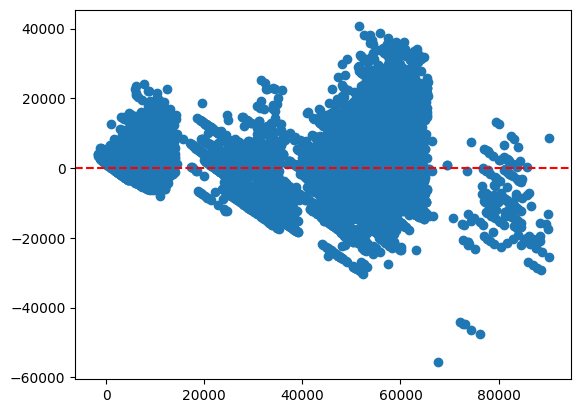

In [100]:
residual=y_test_combined -y_pred_combined
plt.scatter(y_pred_combined, residual)
plt.axhline(0, color='red', linestyle='--')
plt.show()

We can see that it is centered around O, we have some points that are far from the others too

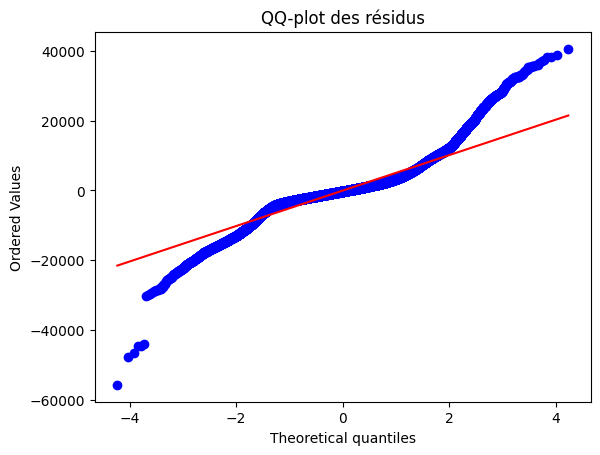

In [101]:
stats.probplot(residual, dist="norm", plot=plt)
plt.title("QQ-plot des résidus")
plt.show()

The residuals don't have a normal distribution, this may indicate that the relation between X and Y is not linear, we altough have a decent model,we will try other methods and will deploy the best of them